In [49]:
import numpy as np
from optiland import analysis, optic, optimization
from optiland.physical_apertures.rectangular import RectangularAperture
from optiland.analysis.irradiance import IncoherentIrradiance
from optiland.analysis.intensity import RadiantIntensity
from optiland.coordinate_system import CoordinateSystem
from optiland.materials import IdealMaterial, Material

from optiland.surfaces import Surface
from optiland.geometries import NurbsGeometry


import optiland.backend as be

In [50]:
import matplotlib.pyplot as plt
import optiland.backend as be

def plot_nurbs_control_points(surface, ax=None, figsize=(10, 8), color='r', label='Control Points'):
    """
    Plots the control points of a NURBS surface in 3D.
    
    Args:
        surface: The surface object containing the NURBS geometry.
        ax: Existing 3D axis to plot on. If None, a new figure is created.
        figsize: Tuple (width, height) for the figure size (only used if ax is None).
        color: Color of the control points and grid lines.
        label: Label for the legend.
    """
    geo = surface.geometry
    
    # Access control points and convert to numpy
    P = be.to_numpy(geo.P)

    # If no axis is provided, create a new figure and axis
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('X [mm]')
        ax.set_ylabel('Y [mm]')
        ax.set_zlabel('Z [mm]')
    
    # Set title if not already present
    if not ax.get_title():
        ax.set_title(f"NURBS Control Points (Surface {surface.name if hasattr(surface, 'name') else 'Unknown'})")

    # Plot control points
    ax.scatter(P[0].flatten(), P[1].flatten(), P[2].flatten(), c=color, marker='o', label=label)

    # Plot grid lines for structure (U direction)
    for i in range(P.shape[1]):
        ax.plot(P[0, i, :], P[1, i, :], P[2, i, :], color=color, linestyle='-', alpha=0.3)

    # Plot grid lines for structure (V direction)
    for j in range(P.shape[2]):
        ax.plot(P[0, :, j], P[1, :, j], P[2, :, j], color=color, linestyle='-', alpha=0.3)

    ax.legend()
    # Return the axis object to allow further plotting
    return ax

In [61]:
lens = optic.Optic(name="carta")

lens.set_field_type("angle")
lens.add_field(y=0)

lens.set_aperture(aperture_type="EPD", value=80)

lens.add_wavelength(value=0.587, is_primary=True)
val = 30
bar=RectangularAperture(
    y_max=val,
    y_min=-val,
    x_max=1,
    x_min=-1,
)
#lens.add_surface(index=0, radius=np.inf, thickness=np.inf)
lens.add_surface(index=0, z=np.inf, y=10, aperture=bar)
lens.add_surface(index=1, z=-100, aperture=bar)
#lens.add_surface(index=2, z=100, radius_y=200,radius_x=np.inf, material="mirror", rx=np.radians(-30), surface_type="toroidal", is_stop=True)


cs = CoordinateSystem(x=0, y=-10, z=0, rx=np.radians(-40), ry=0, rz=0, reference_cs=None)
nurbs_geo = NurbsGeometry(
    coordinate_system=cs,
    nurbs_norm_x = 20,
    nurbs_norm_y = 80,
    n_points_u = 2,
    n_points_v = 13,
)
n_control_points_u = nurbs_geo.P_size_u
n_control_points_v = nurbs_geo.P_size_v
material_post = IdealMaterial(n=1)
new_surface = Surface(geometry=nurbs_geo, material_post=material_post, previous_surface=lens.surface_group.surfaces[1])
new_surface.interaction_model.is_reflective = True
lens.add_surface(index=2, new_surface=new_surface, z=0)

carta_aperture = RectangularAperture(
    y_max=600,
    y_min=-600,
    x_max=50,
    x_min=-50,
)
lens.add_surface(index=3, z=-100, y=-650, aperture=carta_aperture, is_stop=True)
#lens.surface_group.surfaces[1].aperture = aperture
#lens.surface_group.surfaces[2].aperture = carta_aperture
import copy
lens_original = copy.deepcopy(lens)


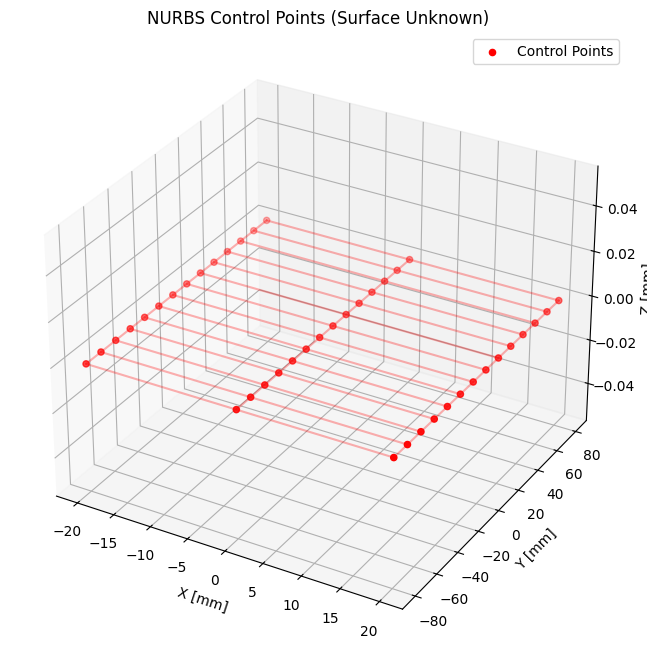

In [52]:
ax = plot_nurbs_control_points(lens.surface_group.surfaces[2])

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Z [mm]', ylabel='Y [mm]'>)

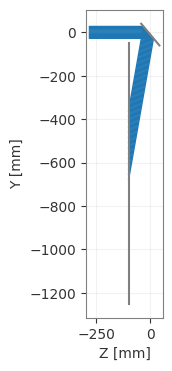

In [62]:
lens.draw(num_rays=20)

In [54]:
problem = optimization.OptimizationProblem()

#for i in range(3):
#    for k in range(n_control_points_v):
#        problem.add_variable(lens, "nurbs_control_points_u", surface_number=2, coeff_index = [i,k], min_val=-120, max_val=200)

for k in range(n_control_points_v):
    problem.add_variable(
        lens,
        "nurbs_control_points_u",
        surface_number=2,
        coeff_index=[2,k],
        min_val=-100,
        max_val=100,
    )

problem.add_variable(
    lens,
    "decenter",
    surface_number=3,
    axis="z",
    min_val = -150,
    max_val = -40,
)

problem.add_variable(
    lens,
    "tilt",
    surface_number=2,
    axis="x",
    min_val = np.radians(-180),
    max_val = np.radians(180),
)
#for k in range(n_control_points_v):
#    problem.add_variable(lens, "nurbs_weights_u", surface_number=2, coeff_index = k, min_val=0, max_val=10)

n_rays = 10
for i in range(n_rays+1):
    input_data = {
        "optic": lens,           # Your lens system
        "surface_number": -1,     # Use -1 for the image plane
        "Hx": 0.0,                # Normalized Field X
        #"Hy": 60/80 -i*2/n_rays * 60/80,                # Normalized Field Y (e.g., full field)
        "Hy": 0.0,
        "Px": 0.0,                # Normalized Pupil X
        "Py": (1-i*2/n_rays)*60/80,                # Normalized Pupil Y (e.g., chief ray)
        "wavelength": 0.587       # Wavelength in microns
        }
    problem.add_operand(
        operand_type="real_y_intercept",
        target=-45-i*1280/n_rays,
        weight=1.0,
        input_data=input_data
    )
    #problem.add_operand(
    #    operand_type="real_x_intercept",
    #    target=0,
    #    weight=1.0,
    #    input_data=input_data
    #)

problem.info()


╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │            1.26171e+06 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤══════════════════╤══════════╤══════════════╤══════════════╤══════════╤══════════╤══════════╤════════════════╕
│    │ Operand Type     │   Target │ Min. Bound   │ Max. Bound   │   Weight │    Value │    Delta │   Contrib. [%] │
╞════╪══════════════════╪══════════╪══════════════╪══════════════╪══════════╪══════════╪══════════╪════════════════╡
│  0 │ real y intercept │      -45 │              │              │        1 │ -346.777 │ -301.777 │           7.22 │
│  1 │ real y intercept │     -173 │              │              │        1 │ -381.33  │ -208.33  │           3.44 │
│  2 │ real y intercept │     -301 │              │              │        1 │ -415.883 │ -114.883 │           1.05 │
│  3 │ real y intercept │     -429 │  

In [55]:
optimizer = optimization.OptimizerGeneric(problem)
#optimizer = optimization.BasinHopping(problem)
#optimizer = optimization.LeastSquares(problem)
history = []
def callback(xk):
    # xk is a numpy array of the current parameters
    history.append(xk)
    print(f"Iteration {len(history)}: x = {xk}")
#res = optimizer.optimize(callback=callback, tol=1e-15, method_choice="trf")
res = optimizer.optimize(callback=callback, tol=1e-15)
#optimizer = optimization.DifferentialEvolution(problem)
#res = optimizer.optimize(maxiter=5, workers=-1)
problem.info()

Iteration 1: x = [   0.            0.            0.            0.31347069    0.31347069
   -0.31347069   -0.31347069   -0.31347069   -0.31347069   -0.31347069
   -0.31347069    0.31347069    0.31347069    0.         -100.15673535
   -0.70579123]
Iteration 2: x = [   0.            0.            0.            0.26790027    0.26794134
   -0.26724506   -0.26810203   -0.26825847   -0.26821808   -0.26809236
   -0.26798449    0.26805353    0.26803082    0.         -100.134009
   -0.7144495 ]
Iteration 3: x = [   0.            0.            0.            0.21364779    0.21370938
   -0.21263566   -0.21395823   -0.21420593   -0.2141432    -0.21394848
   -0.21378063    0.2138923     0.21385387    0.         -100.10691534
   -0.7179871 ]
Iteration 4: x = [   0.            0.            0.            0.22234436    0.22240075
   -0.21940848   -0.22319004   -0.22427368   -0.22405922   -0.22325685
   -0.22261055    0.2233641     0.22310977    0.         -100.11141467
   -0.71699405]
Iteration 5: x = [

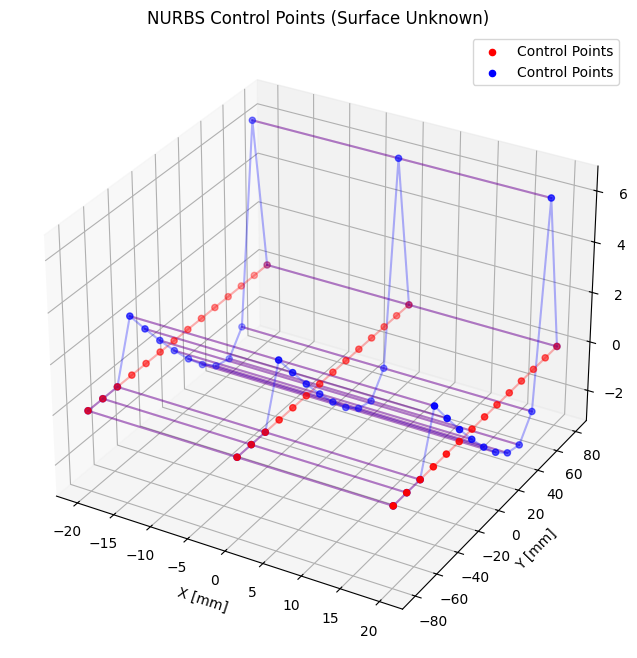

In [56]:
plot_nurbs_control_points(lens.surface_group.surfaces[2], color='b', ax=ax)
display(ax.figure)

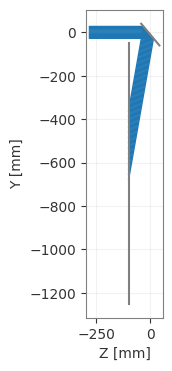

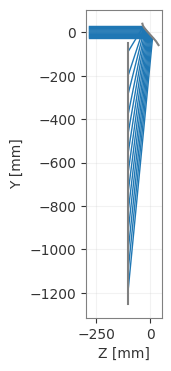

In [57]:
import ipywidgets as widgets
fig1, ax1 = lens_original.draw(num_rays=20)
fig2, ax2 = lens.draw(num_rays=20)


# Wrap them in Output widgets
out1 = widgets.Output()
out2 = widgets.Output()

with out1:
    display(fig1)
with out2:
    display(fig2)

# Display side-by-side
widgets.HBox([out1, out2])

1
12800


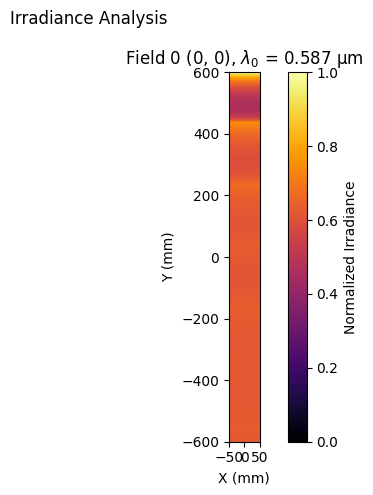

In [58]:
irradiance = IncoherentIrradiance(
    lens,
    #num_rays=1000_000,  # 1 million rays
    num_rays=1_000_000,
    detector_surface=-1,  # image surface
    distribution="line_y",
    res=[1,12800]
)
irradiance.view(normalize=True)
irr_data = irradiance.data
print(irradiance.npix_x)
print(irradiance.npix_y)

In [59]:
i = 0
for fblock in irr_data:
    for irr, *_ in fblock:
        irr_mean=be.mean(irr)
        irr_std=be.std(irr)
        irr_max=be.max(irr)
        irr_min=be.min(irr)

        if irr_mean > 0:
            rms_uniformity = irr_std / irr_mean
        else:
            rms_uniformity = 0

        if irr_mean > 0:
            irr_uniformity = (irr_max - irr_min) / irr_mean
        else:
            irr_uniformity = 0

print(irr_mean)
print(irr_uniformity)
print(rms_uniformity)
print(irr_max)
print(irr_min)

5.844191666666667
0.8760835188213938
0.09001115522958095
9.386666666666667
4.266666666666667


In [60]:
from optiland.fileio import save_optiland_file
save_optiland_file(lens, "optimization1.json")